<a href="https://colab.research.google.com/github/Onyi-RICH/Forcasting_Time_Series_Project/blob/main/Copy_of_guayas_prepared.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Corporación Favorita Grocery Sales Forecasting Project


**Goal:
Predict unit_sales per store_id and item_id, per day, for stores in Guayas region.**



# Part 1- Installation and Liberaries importation

✅ Step 0: Install Required Packages

In [ ]:
!pip install -U gdown
!pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 83.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 15.5 MB/s eta 0:00:00


✅ Step 1: Import Libraries

In [ ]:
#  Ignore warning suggetions given by Python
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import requests
import gdown
import io
from matplotlib import pyplot as plt
import seaborn as sns
from google.colab import drive
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
# Build the download URL from a file ID
def make_drive_url(file_id):
    return f"https://drive.google.com/uc?id={file_id}"

# Helper function to load a CSV from a direct URL
def load_csv_from_url(url):
    response = requests.get(url)
    response.raise_for_status()  # Raises an error if the request fails
    return pd.read_csv(io.StringIO(response.text))

✅ Step 2: Dictionary of file IDs for clarity

In [ ]:
file_ids = {
    "holiday_events": "1RMjSuqHXHTwAw_PGD5XVjhA3agaAGHDH",
    "items": "1ogMRixVhNY6XOJtIRtkRllyOyzw1nqya",
    "oil": "1Q59vk2v4WQ-Rpc9t2nqHcsZM3QWGFje_",
    "stores": "1Ei0MUXmNhmOcmrlPad8oklnFEDM95cDi",
    "train": "1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv",
    "transactions": "1PW5LnAEAiL43fI5CRDn_h6pgDG5rtBW_"
}

✅ Step 3: Load each CSV using the helper functions

In [ ]:
# Load all files using the helper functions except train.csv

df_holiday_events = load_csv_from_url(make_drive_url(file_ids["holiday_events"]))
df_items          = load_csv_from_url(make_drive_url(file_ids["items"]))
df_oil            = load_csv_from_url(make_drive_url(file_ids["oil"]))
df_stores         = load_csv_from_url(make_drive_url(file_ids["stores"]))
df_transactions   = load_csv_from_url(make_drive_url(file_ids["transactions"]))
# df_train          = load_csv_from_url(make_drive_url(file_ids["train"]))

# Note: train file is very large.
# To make sure we fit RAM avaible on Google-Colab, we will load only part of the file


In [ ]:
# Quick Test to Confirm
display(df_stores.head())
display(df_items.head())
display(df_holiday_events.head())
display(df_oil.head())
display(df_transactions.head())


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


What each dataframe represents:
- df_train – daily sales by store and product
- df_items – details about each item
- df_stores – store locations and types
- df_oil – oil prices (a possible external influence on sales)
- df_transactions – total store traffic per day
- df_holiday_events – national/local holidays and special events

In [ ]:
# Download the train.csv file using gdown
train_url = make_drive_url(file_ids["train"])
gdown.download(train_url, "train.csv", quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv
From (redirected): https://drive.google.com/uc?id=1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv&confirm=t&uuid=50a62112-942d-40c5-8dd8-94428204a4fa
To: /content/train.csv
100%|██████████| 5.00G/5.00G [01:18<00:00, 63.5MB/s]


'train.csv'

# Part 2: Exploratory Data Analysis (EDA)

 We need to filter out the data to get **only Guayas region**.

we can experiment with different chunksize values.
A chunksize of 100,000 to 1,000,000 rows is a good starting point.


In [ ]:
# Select list of stores located in the 'Guayas' region
store_ids = df_stores[df_stores['state'] == 'Guayas']['store_nbr'].unique()

# Initialize an empty list to hold filtered chunks
filtered_chunks = []

# Define the chunk size (number of rows per chunk)
chunk_size = 10 ** 6              # Read 1 million rows at a time & Adjust based on system's memory capacity

# Read the CSV file in chunks
for chunk in pd.read_csv('./train.csv', chunksize=chunk_size):
  chunk_filtered = chunk[chunk['store_nbr'].isin(store_ids)]  # Filter the chunk for the desired store IDs
  filtered_chunks.append(chunk_filtered)                    # Append the filtered chunk to the list

  del chunk                                                 # Delete the chunk to free up memory

# Concatenate all filtered chunks into a single DataFrame
df_train = pd.concat(filtered_chunks, ignore_index=True)      # ignore index set to TRUE, so that we don't have any problems during concatenation.



del filtered_chunks             # Delect and Clean up to free memory

In [ ]:
df_train.shape

(22941656, 6)

The dataset that we have is still very big even after filtering. To prevent our work from unexpected crashes, let's limit the dataset to include only top-3 families by number of items but first let's look at this top-3:

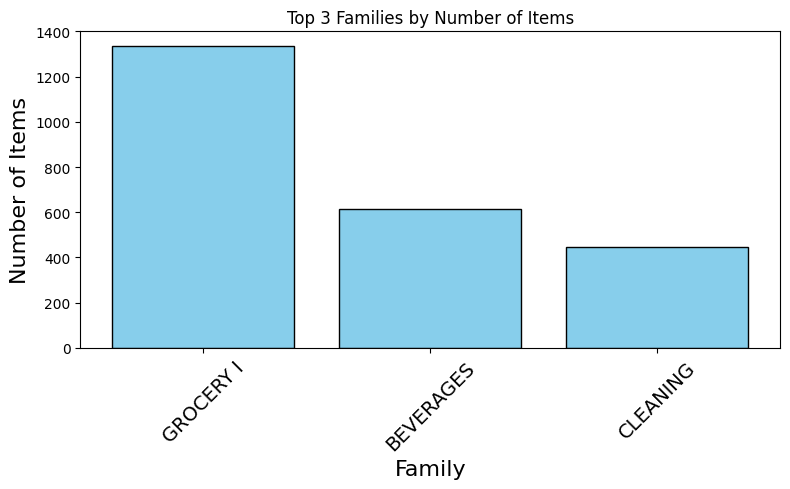

'\nwe have groceries, beverages and cleaning.\nSo these are top 3 families of items that customers normally purchase.\nthis is a part of EDA exploratory data analysis.\n'

In [ ]:
# # Compute the number of items per family and select the top 3 families
items_per_family = df_items['family'].value_counts().reset_index()
items_per_family.columns = ['Family','Item Count'] # rename items_per_family
top_3_families = items_per_family.head(3) # [:3]  #  no need to do any sorting, because Value counts already returns it in descending order.

# plot the top 3 family
plt.figure(figsize = (8,5))
plt.bar(top_3_families['Family'], top_3_families['Item Count'],
        color = 'skyblue', edgecolor = 'black')
plt.title('Top 3 Families by Number of Items')
plt.xlabel("Family", fontsize=16)
plt.ylabel("Number of Items", fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.tight_layout()
plt.show()

"""
we have groceries, beverages and cleaning.
So these are top 3 families of items that customers normally purchase.
this is a part of EDA exploratory data analysis.
"""

we want to filter a little further.

In [ ]:
# we want to filter a little further. We already filtered on the Guayas region
# So I want to filter again my train data on these for these item

top_3_families['Family'].unique()

array(['GROCERY I', 'BEVERAGES', 'CLEANING'], dtype=object)

In [ ]:
#  filtering items that only belong to groceries, beverages, and cleaning.
# And use this list of items to filter training dataset.

item_ids = df_items[df_items['family'].isin(top_3_families['Family'].unique())]['item_nbr'].unique()
df_train = df_train[df_train['item_nbr'].isin(item_ids)]          # Df train will be the DF train where df_train item number is in item_ids.


In [ ]:
# Sample to 2 Millons
df_train_filtered = df_train.copy()
print(f"Filtered dataset size: {len(df_train_filtered):,} rows")

if len(df_train_filtered) > 2_000_000:
    df_train_sample = df_train_filtered.sample(n=2_000_000, random_state=42).copy()
    print(f"Sampled down to {len(df_train_sample):,} rows")
else:
    df_train_sample = df_train_filtered.copy()
    print(f"Dataset sample now has {len(df_train_sample):,} rows")

# Update master_df to use the sampled version for analysis
df_train = df_train_sample.copy()

Filtered dataset size: 14,745,768 rows
Sampled down to 2,000,000 rows


From around 22.9 millions of rows to around 2 millions. This is our reduction.

In [ ]:
# Checking missing values
df_train.isnull().sum()

,0
id,0
date,0
store_nbr,0
item_nbr,0
unit_sales,0
onpromotion,372449


# Part 3: Data Preprocessing or preparation

**step 3.1 Handling missing value**

In [ ]:
df_train['onpromotion'].value_counts()  # check the value count

,count
onpromotion,
False,1534722
True,92829


In [ ]:
# Imputate or fill them with FALSE(to most occured values)
df_train.fillna({'onpromotion': False}, inplace=True)

In [ ]:
# Verify that the missing values are now handled
print("Missing values after filling 'onpromotion':")
print(df_train.isnull().sum())

Missing values after filling 'onpromotion':
id             0
date           0
store_nbr      0
item_nbr       0
unit_sales     0
onpromotion    0
dtype: int64


**Step 3.2: Check Target variable and handle any negative values in Unit sales**





check if there are negative unit sales(returned items)

In [ ]:
negative_sales = df_train[df_train['unit_sales']<0]
print("Number of rows with negative sales:", len(negative_sales))
negative_sales.head()

Number of rows with negative sales: 100


,id,date,store_nbr,item_nbr,unit_sales,onpromotion
10547565,57419947,2015-09-24,29,1463484,-5.0,False
13034064,71021589,2016-02-19,27,472314,-1.0,False
54236,309805,2013-01-09,35,1079215,-8.0,False
20807971,113492918,2017-04-24,35,305344,-2.0,False
4436262,24310381,2014-05-24,36,155625,-2.0,False


**Handling negative values in Unit sales(Target)**

we basically want to justify they were not sold but were returned by replacing or transforming them with 0.

In [ ]:
df_train['unit_sales'] = df_train['unit_sales'].apply(lambda x: max(x,0))

**Step 3.3 Detecting and handling Outliers**

The Z-score method is useful for detecting extreme values that are statistically unlikely.


In [ ]:
# Function to calculate Z-score for each group (store-item combination)

def calculate_store_item_zscore(group):   # defined a function calculate store item and group as my vector
  # Compute mean and standard deviation for each store-item group
  mean_sales = group['unit_sales'].mean()
  std_sales = group['unit_sales'].std()

  # Calculate Z-score (avoiding division by zero for standard deviation)
  group['z_score'] = (group['unit_sales'] - mean_sales)/(std_sales if std_sales !=0 else 1)
  return group                                 # !=0 avoid division by 0.if Std sales doesn't equal to 0, else let's set it to one.

In [ ]:
# Lets group our data by store_number and item_number.
# we will calculate the Z score

df_train_grouped = df_train.groupby(['store_nbr', 'item_nbr']).apply(calculate_store_item_zscore)     # this is how the group is formed
df_train_grouped.reset_index(drop=True, inplace=True)              # this will result in store and item being in the index, so I can reset them to become again the columns using (drop=True, inplace=True)

In [ ]:
# Count Frequency of Each Sale Value

sales_counts = df_train_grouped['unit_sales'].value_counts().sort_index()
print("Top unit_sales before capping:\n", sales_counts.tail(20))


Top unit_sales before capping:
 unit_sales
1804.0    1
1812.0    1
1947.0    1
1948.0    1
1960.0    1
2414.0    1
2416.0    1
2425.0    1
2530.0    1
2534.0    1
2537.0    1
2548.0    1
2732.0    1
2733.0    1
2754.0    1
3102.0    1
3366.0    1
3624.0    1
3713.0    1
5473.0    1
Name: count, dtype: int64


In [ ]:
# Zoom In on High Values
# To focus only on values above a certain threshold (say 50):
df_train_grouped[df_train_grouped['unit_sales'] > 50]['unit_sales'].value_counts().sort_index()


,count
unit_sales,
51.0,947
52.0,902
53.0,880
54.0,870
55.0,795
...,...
3102.0,1
3366.0,1
3624.0,1


**Handling Outliers**



In [ ]:
# Calculate 99th percentile for unit_sales (GLOBAL, not per group)
# Useful for Tree-based models

cap_99 = df_train['unit_sales'].quantile(0.99)
print(f"99th percentile cap value: {cap_99}")

# Apply 99th percentile cap
df_train['unit_sales_capped'] = np.where(
    df_train['unit_sales'] > cap_99,
    cap_99,
    df_train['unit_sales']
)


# Log Transform (stabilizes variance, handles skew) to capped values which is useful for Classical models
df_train['log_unit_sales'] = np.log1p(df_train['unit_sales_capped'])

99th percentile cap value: 57.0


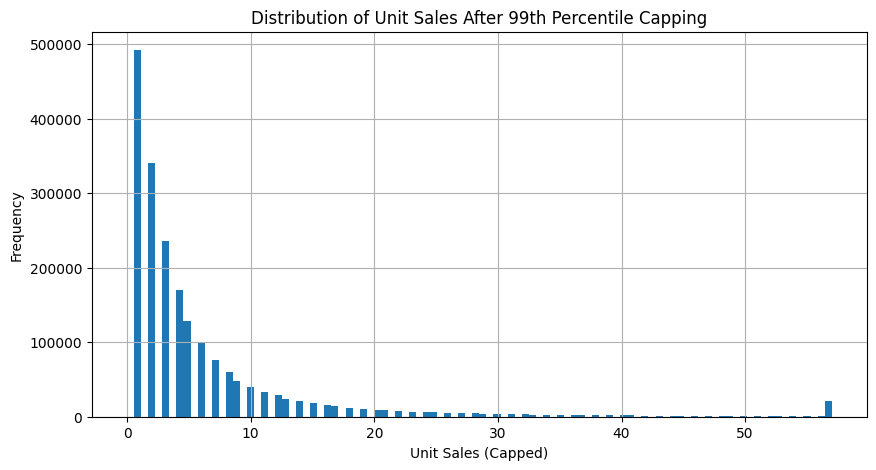

In [ ]:
# Optional Visual Check – Capped Distribution
plt.figure(figsize=(10, 5))
df_train['unit_sales_capped'].hist(bins=100)
plt.title("Distribution of Unit Sales After 99th Percentile Capping")
plt.xlabel("Unit Sales (Capped)")
plt.ylabel("Frequency")
plt.show()


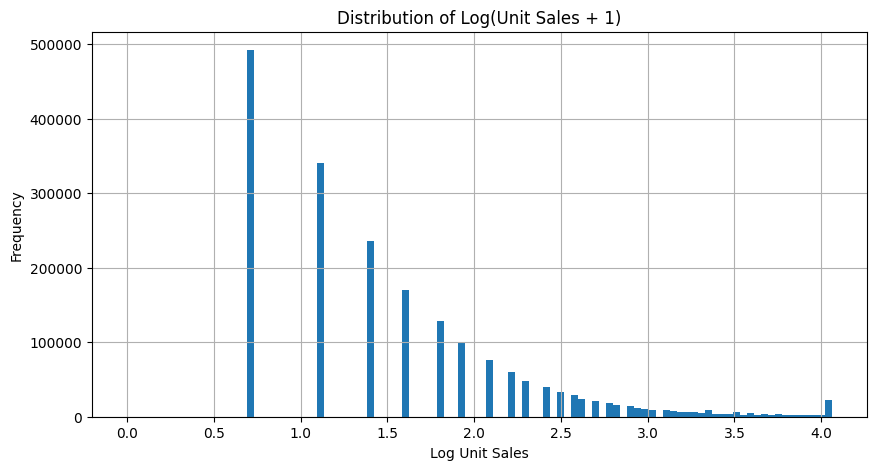

In [ ]:
# Optional Visual Check – Log-Transformed
plt.figure(figsize=(10, 5))
df_train['log_unit_sales'].hist(bins=100)
plt.title("Distribution of Log(Unit Sales + 1)")
plt.xlabel("Log Unit Sales")
plt.ylabel("Frequency")
plt.show()

**Step 3.4 - Handling missing Dates**

Fill missing dates with zero sales

In [ ]:
# Convert 'date' column to datetime format
df_train['date'] = pd.to_datetime(df_train['date'])

# Get the minimum and maximum dates in the dataset to create a full date range
min_date = df_train['date'].min()
max_date = df_train['date'].max()

# Create full date range
full_date_range = pd.DataFrame({'date': pd.date_range(min_date, max_date, freq='D')})
full_date_range

,date
0,2013-01-02
1,2013-01-03
2,2013-01-04
3,2013-01-05
4,2013-01-06
...,...
1682,2017-08-11
1683,2017-08-12
1684,2017-08-13
1685,2017-08-14


Next, let's create a DataFrame with all (store, item, date) combinations

In [ ]:
# Get unique store-item pairs
store_items = df_train[['store_nbr', 'item_nbr']].drop_duplicates()

# Convert full date range to DataFrame
date_df = pd.DataFrame({'date': full_date_range['date']}) # Use the 'date' column from the existing full_date_range DataFrame

# Cartesian product: store × item × date combinations
all_combinations = store_items.merge(date_df, how='cross') # Use how='cross' for Cartesian product
all_combinations

,store_nbr,item_nbr,date
0,32,1395693,2013-01-02
1,32,1395693,2013-01-03
2,32,1395693,2013-01-04
3,32,1395693,2013-01-05
4,32,1395693,2013-01-06
...,...,...,...
34711707,34,1304491,2017-08-11
34711708,34,1304491,2017-08-12
34711709,34,1304491,2017-08-13
34711710,34,1304491,2017-08-14


now we are finally ready to fill up the original data with missing dates by merging two dataframes

In [ ]:
# Merge with original data to fill missing dates
df_filled = all_combinations.merge(df_train,
                                   on = ['store_nbr', 'item_nbr', 'date'],
                                   how ='left')
# Fill missing values after merge
df_filled['unit_sales'] = df_filled['unit_sales'].fillna(0)
df_filled['onpromotion'] = df_filled['onpromotion'].fillna(False).astype(int) # Best for modeling

# Check the first few rows
df_filled.head(5)

,store_nbr,item_nbr,date,id,unit_sales,onpromotion,unit_sales_capped,log_unit_sales
0,32,1395693,2013-01-02,NaN,0.0,0,NaN,NaN
1,32,1395693,2013-01-03,NaN,0.0,0,NaN,NaN
2,32,1395693,2013-01-04,NaN,0.0,0,NaN,NaN
3,32,1395693,2013-01-05,NaN,0.0,0,NaN,NaN
4,32,1395693,2013-01-06,NaN,0.0,0,NaN,NaN


Now we have all dates and corresponding sales for them. Let's replace the original dataframe

In [ ]:
# Drop Id column and assign to df_train
df_filled = df_filled.drop(columns=['id'], errors='ignore')

# Assign final version to df_train
df_train = df_filled.copy()
del df_filled, store_items, date_df, all_combinations  # now safe to delete

**Recompute capped and log sales**

Why?

we introduced new 0s for previously missing records. These zeros weren’t in the original distribution, so our old cap_99 is no longer valid.



In [ ]:
# Recompute capped and log-transformed sales columns

cap_99 = df_train['unit_sales'].quantile(0.99)
df_train['unit_sales_capped'] = np.where(df_train['unit_sales'] > cap_99, cap_99, df_train['unit_sales'])
df_train['log_unit_sales'] = np.log1p(df_train['unit_sales_capped'])


**Step 3.5 Data Analysis**

Time Series Analysis for One Store-Item in Guayas

- Stationarity checks (ADF test)

- Seasonal decomposition (to decide on SARIMA)

- ACF & PACF plots (to select AR/MA orders)

📌 These models work on univariate time series, and require stationarity.

<Axes: title={'center': 'Unit Sales over Time'}, xlabel='date'>

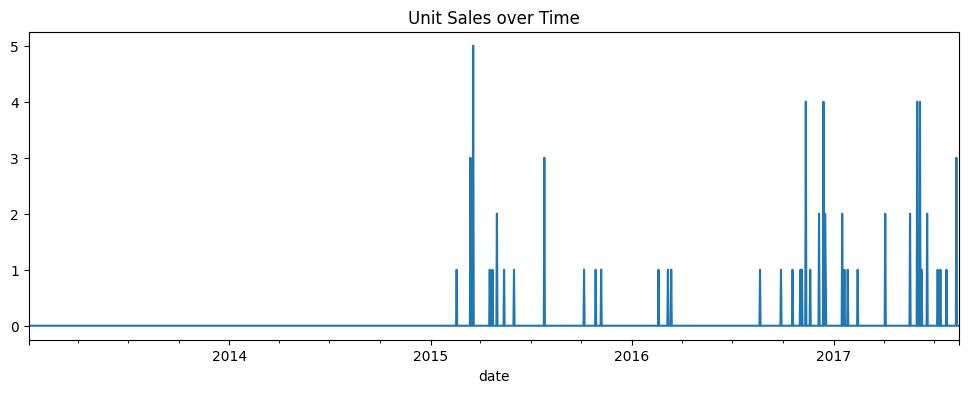

In [ ]:
# 1. Select a Store + Item Combination

# pick one store-item pair in Guayas
sample_series = df_train[
    (df_train['store_nbr'] == 24) & (df_train['item_nbr'] == 1395693)
].sort_values('date')

# Set date as index and ensure daily frequency
sample_series = sample_series.set_index('date').asfreq('D')
sample_series['unit_sales'] = sample_series['unit_sales'].fillna(0)

# Plot
sample_series['unit_sales'].plot(figsize=(12, 4), title="Unit Sales over Time")


In [ ]:
#  2. ADF Test for Stationarity
from statsmodels.tsa.stattools import adfuller

result = adfuller(sample_series['unit_sales'])

print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] < 0.05:
    print("✅ The time series is stationary.")
else:
    print("⚠️ The time series is NOT stationary.")


ADF Statistic: -6.579206824163871
p-value: 7.588858379972454e-09
✅ The time series is stationary.


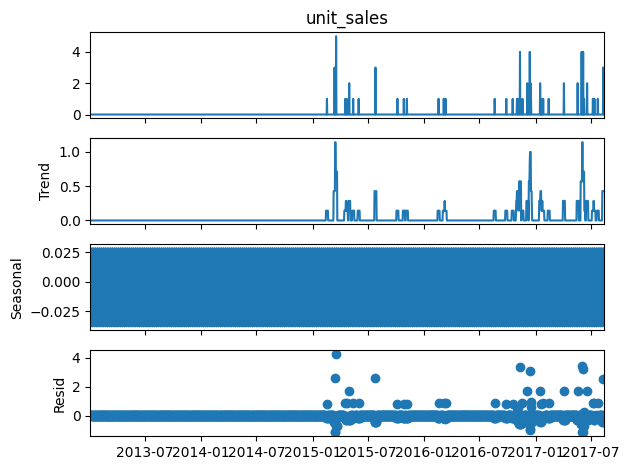

In [ ]:
# 3. Seasonal Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(sample_series['unit_sales'], model='additive', period=7)  # weekly
decomposition.plot();


| Component       | What You Saw                      | What It Means                                |
| --------------- | --------------------------------- | -------------------------------------------- |
| **Trend**       | clear increasing trend in unit sales over time  | Irregular sales, more frequent and slightly higher from 2015 onwards |
| **Seasonality** | Flat or noisy seasonal component  | No clear weekly selling pattern or cycle                        |
| **Residual**    | Large noise/ unexplained variance                      | Sales are likely driven by unobserved events |


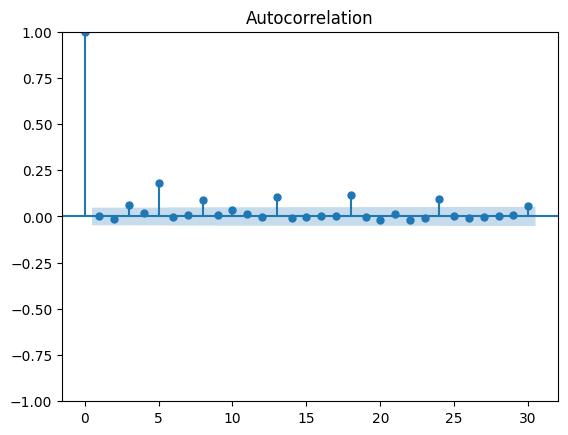

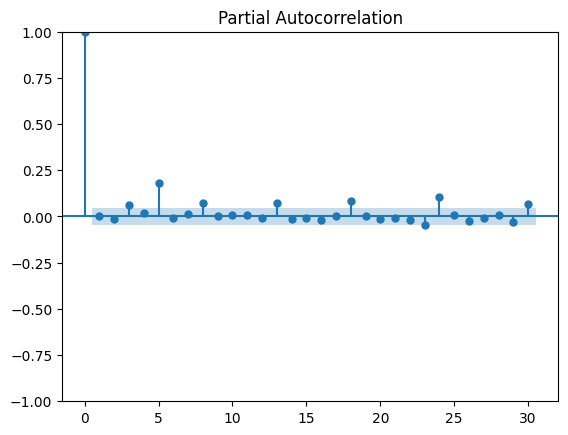

In [ ]:
#  4. ACF & PACF Plots

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(sample_series['unit_sales'], lags=30);
plot_pacf(sample_series['unit_sales'], lags=30);

**Step 3.6. Feature Engineering**

This is a critical step to extract meaningful signals from our raw data. The goal is to enrich our df_train DataFrame with as much predictive information /features as possible that help the model understand the patterns in the sales data.

**A - Time-Based Features**

These features capture the inherent seasonality and cyclical patterns of your data.

In [ ]:
# given that 'date' column is already in datetime format
df_train['day'] = df_train['date'].dt.day
df_train['month'] = df_train['date'].dt.month
df_train['year'] = df_train['date'].dt.year
df_train['day_of_week'] = df_train['date'].dt.dayofweek  # Monday=0, Sunday=6
df_train['is_weekend'] = df_train['day_of_week'].isin([5, 6]).astype(int)
df_train['weekofyear'] = df_train['date'].dt.isocalendar().week.astype(int) # # 1 for Sat/Sun


 **B. Lag features (memory from past days)**

Useful for models like XGBoost or LSTM to learn temporal dependencies. we'll need to use groupby to create these features.

In [ ]:
df_train['sales_lag_1'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales'].shift(1)
df_train['sales_lag_7'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales'].shift(7)
df_train['sales_lag_14'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales'].shift(14)
df_train['sales_lag_28'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales'].shift(28)  # Lag by 28 days

**C. Rolling/Expanding Features**

Helps capture smoothed trends

In [ ]:
# For the first 6 days, 'rolling_mean_7d' will be NaN because the window size is 7 (need 7 previous values)
df_train['rolling_mean_7d'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales'] \
    .transform(lambda x: x.shift(1).rolling(window=7).mean())    # 7-day rolling mean, shifted to exclude current row

# For earlier rows, 'expanding_mean' calculates the mean of all previous values, so it does not have the same NaN issue
df_train['expanding_mean'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales'] \
    .transform(lambda x: x.shift(1).expanding().mean())          # Expanding mean, shifted to exclude current row

# 28-day rolling mean will have NaN for the first 27 days for the same reason as above
df_train['rolling_mean_28d'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales'] \
    .transform(lambda x: x.shift(1).rolling(window=28).mean())   # 28-day rolling mean, shifted to exclude current row

**D. Special Days / Holidays**  
— Using df_holiday_events

In [ ]:
# Step 0: Convert date column to datetime in the original holidays data
df_holiday_events['date'] = pd.to_datetime(df_holiday_events['date'])
print("Holidays range: from", df_holiday_events['date'].dt.date.min(), "till", df_holiday_events['date'].dt.date.max())

# Step 1: Filter out transferred holidays
df_holidays = df_holiday_events[df_holiday_events['transferred'] == False].copy()

# Step 2: Merge holiday info into df_train (only 'type' column for now)
df_train = df_train.merge(df_holidays[['date', 'type']], on='date', how='left')

# Step 3: Create holiday features
df_train['is_holiday'] = df_train['type'].notna().astype(int)         # Binary holiday flag
df_train['holiday_type'] = df_train['type'].fillna('None')           # Categorical holiday type

# Step 4: Drop now-redundant 'type' column
df_train.drop(columns=['type'], inplace=True)



Holidays range: from 2012-03-02 till 2017-12-26


**E. Paydays**

Paydays usually happen on 15th and end of month (eg, 30 or 31).

In [ ]:
# Create a new DataFrame 'paydays' by filtering holiday_events

paydays = df_holiday_events[df_holiday_events['description'].str.contains('Pay day', na=False)][['date']].copy()

# Add a flag column to 'paydays'
paydays['is_payday'] = 1

# Ensure the 'date' column is in the correct format for merging
df_train['date'] = pd.to_datetime(df_train['date'])

# Merge the 'paydays' information into the main training DataFrame
df_train = df_train.merge(paydays, on='date', how='left', suffixes=('_original', '_holiday'))

# Fill any NaN values in the new 'is_payday_holiday' column with 0
df_train['is_payday_holiday'] = df_train['is_payday_holiday'].fillna(0)

 **F. Oil Prices (external signal)**

 — Using df_oil

In [ ]:
df_oil['date'] = pd.to_datetime(df_oil['date'])

# Fill forward missing oil prices
df_oil['dcoilwtico'].fillna(method='ffill', inplace=True)

# Merge into df_train
df_train = df_train.merge(df_oil, on='date', how='left')

# fill remaining NaNs (if any)
df_train['dcoilwtico'].fillna(method='bfill', inplace=True)


In [ ]:
# lag and roll the oil prices basically needed for ML
df_train['dcoilwtico_lag1'] = df_train['dcoilwtico'].shift(1)
df_train['dcoilwtico_rolling7'] = df_train['dcoilwtico'].rolling(7).mean()


# Step 4-Visualizing Time-Series Data

- creates insightful visualizations that apply to the entire Guayas region.


**Overall Sales Trend**

A plot of the total sales over time for the entire region will reveal the macro trends and major events.

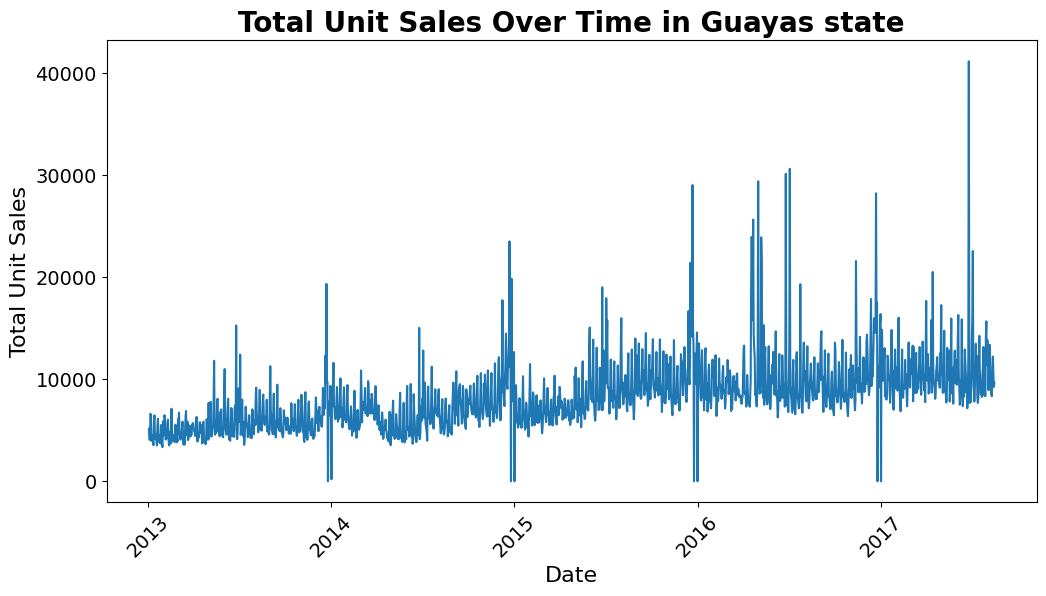

In [ ]:
# Aggregating total sales by date
sales_by_date = df_train.groupby('date')['unit_sales'].sum()

# Plotting the time-series
plt.figure(figsize=(12,6))
plt.plot(sales_by_date.index, sales_by_date.values)
plt.title('Total Unit Sales Over Time in Guayas state', fontsize=20, fontweight='bold')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Total Unit Sales', fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.show()

**monthly Seasonal Heatmap**

A heatmap is an excellent way to visualize monthly sales patterns for the entire region.

Text(0.5, 1.0, 'Monthly Sales Trends Over Years')

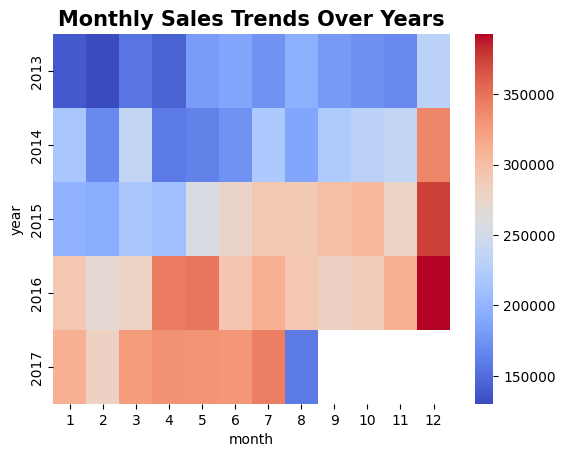

In [ ]:
sales_by_month = df_train.groupby(['year', 'month'])['unit_sales'].sum().unstack()
sns.heatmap(sales_by_month, cmap='coolwarm')

plt.title('Monthly Sales Trends Over Years', fontsize=15, fontweight='bold')


#### **Impact of Special Features:**

**Impact of Pay Days on Unit Sales.**

Pay days are usually associated with a spike in consumer spending.

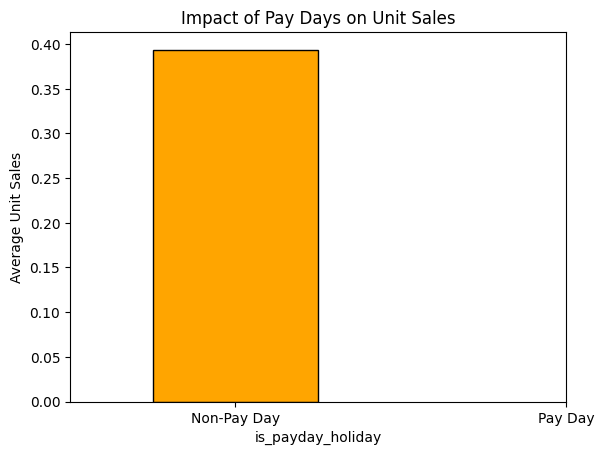

In [ ]:
# Group the data by the new feature and calculate the average sales
payday_impact = df_train.groupby('is_payday_holiday')['unit_sales'].mean()

# Plot the result to visually represent the impact
payday_impact.plot(kind='bar', color='orange', edgecolor='black')
plt.title("Impact of Pay Days on Unit Sales")
plt.xticks(ticks=[0, 1], labels=['Non-Pay Day', 'Pay Day'], rotation=0)
plt.ylabel("Average Unit Sales")
plt.show()

**Examining the Impact of Holiday Types on Sales.**

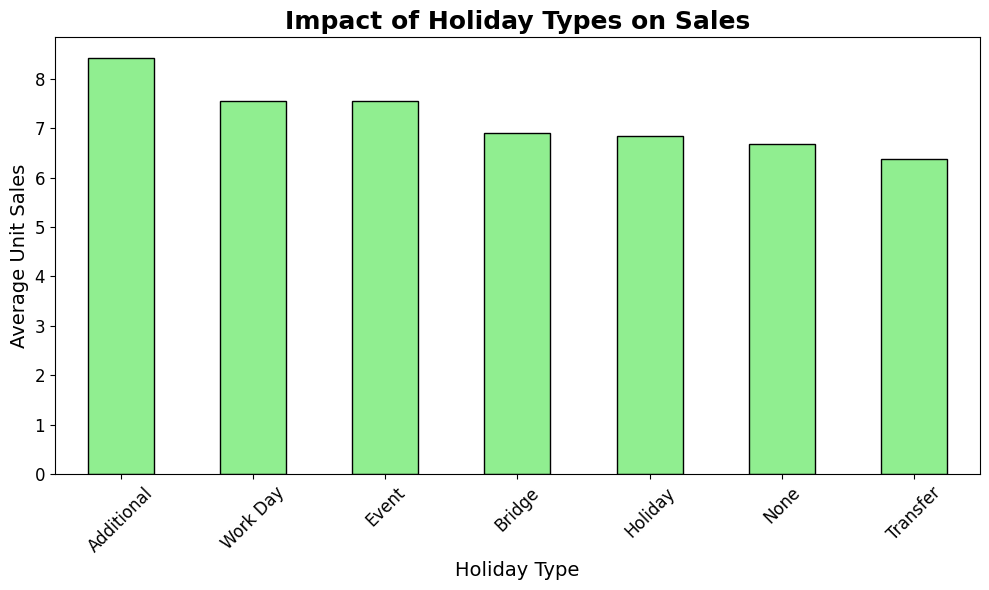

In [ ]:
# Step 1: Remove zero-sale rows to focus on actual sales behavior
df_train_no_zero = df_train[df_train['unit_sales'] > 0]

# Step 2: Sample the dataset for easier plotting
sample = df_train_no_zero.sample(n=500_000, random_state=42)

# Step 3: Group by holiday type and calculate average sales
holiday_sales = sample.groupby('holiday_type')['unit_sales'].mean().sort_values(ascending=False)

# Step 4: Plot holiday impact on sales
plt.figure(figsize=(10, 6))
holiday_sales.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('Impact of Holiday Types on Sales', fontsize=18, fontweight='bold')
plt.ylabel('Average Unit Sales', fontsize=14)
plt.xlabel('Holiday Type', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()



plot the **Average Sales: Perishable vs. Non-Perishable** bar chart.

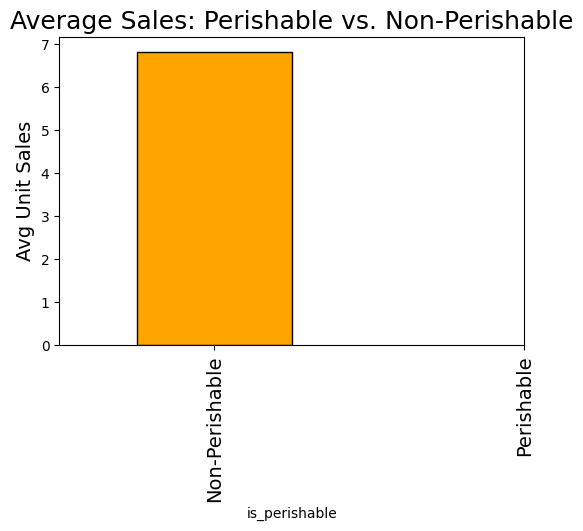

In [ ]:
# Merge the perishable column into the main training data.
# Ensure all columns from df_items are included in the merge to get the 'perishable' column
df_train = df_train.merge(df_items[['item_nbr', 'perishable']], on='item_nbr', how='left')
df_train['is_perishable'] = df_train['perishable'].apply(lambda x: 1 if x > 0 else 0)

# Drop the original 'perishable' column from df_train after creating 'is_perishable'
df_train.drop(columns=['perishable'], inplace=True, errors='ignore')

avg_sales_perish = df_train[df_train['unit_sales'] > 0].groupby('is_perishable')['unit_sales'].mean()

plt.figure(figsize=(6,4))
avg_sales_perish.plot(kind='bar', color=['orange', 'steelblue'], edgecolor='black')
plt.title('Average Sales: Perishable vs. Non-Perishable', fontsize=18)
plt.xticks([0, 1], ['Non-Perishable', 'Perishable'], fontsize=14)
plt.ylabel('Avg Unit Sales', fontsize=14)
plt.show()

####**Relationship Plots:**

 Analyzing Perishable Items- Total Unit Sales Over Time for Perishable vs. Non-Perishable Items.

Evaluate if perishable products behave differently in sales patterns.

<Figure size 1500x600 with 0 Axes>

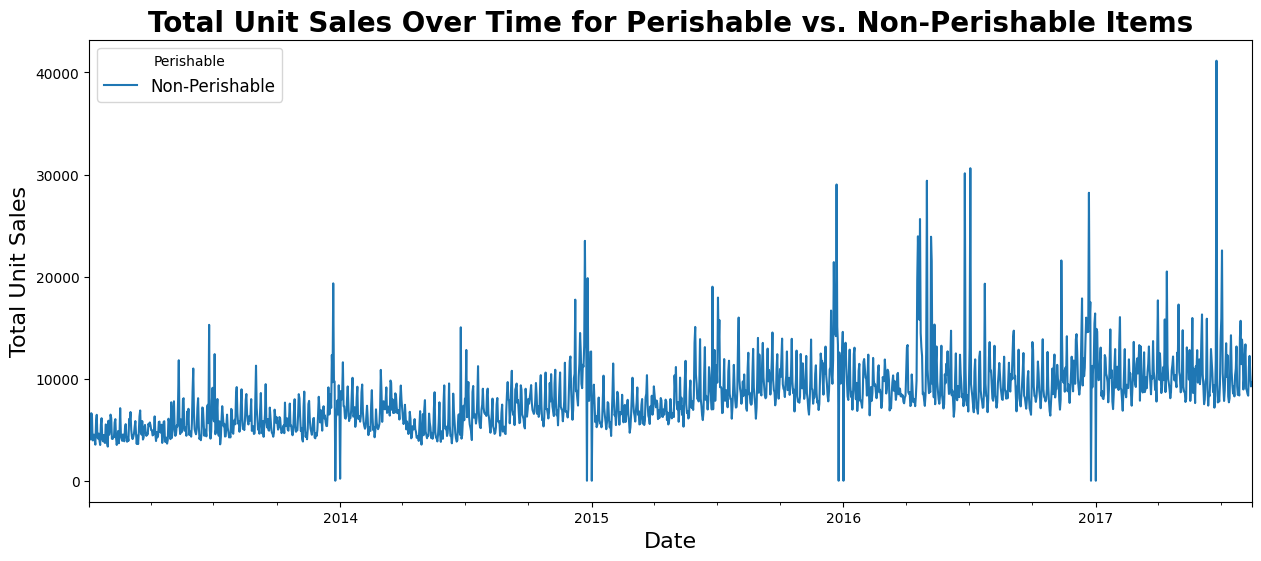

In [ ]:
# Aggregate sales by date and perishability
perishable_sales_by_date = df_train.groupby(['date', 'is_perishable'])['unit_sales'].sum().unstack()

# Plotting the sales trends for perishable vs. non-perishable items
plt.figure(figsize=(15, 6))
perishable_sales_by_date.plot(figsize=(15, 6))
plt.title('Total Unit Sales Over Time for Perishable vs. Non-Perishable Items', fontsize=20, fontweight='bold')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Total Unit Sales', fontsize=16)
plt.legend(title='Perishable', labels=['Non-Perishable', 'Perishable'], fontsize=12)
plt.show()

Oil Prices vs Sales- Does sales volume go up/down when oil prices rise?

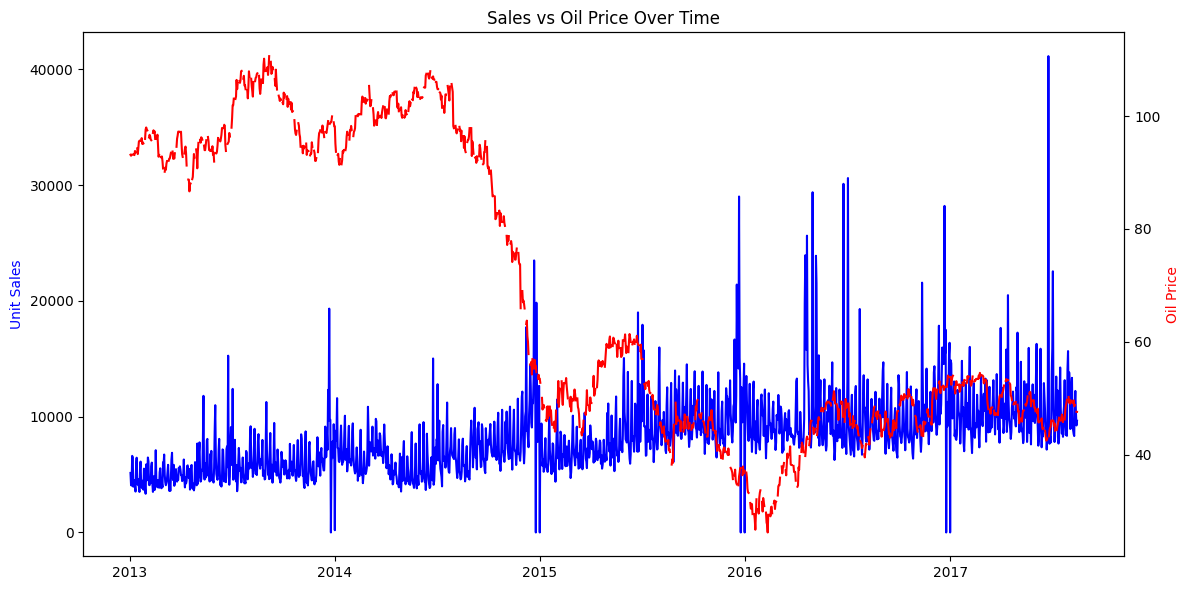

In [ ]:
# Step 1: Ensure date columns are datetime
df_oil['date'] = pd.to_datetime(df_oil['date'])
df_train['date'] = pd.to_datetime(df_train['date'])

# Step 2: Aggregate total sales per day
daily_sales = df_train.groupby('date')['unit_sales'].sum().reset_index()

# Step 3: Merge oil prices with sales
df_sales_oil = pd.merge(daily_sales, df_oil, on='date', how='left')

# Step 4: Plot

fig, ax1 = plt.subplots(figsize=(12,6))

# Sales
ax1.plot(df_sales_oil['date'], df_sales_oil['unit_sales'], color='blue', label='Unit Sales')
ax1.set_ylabel('Unit Sales', color='blue')

# Oil price (second axis)
ax2 = ax1.twinx()
ax2.plot(df_sales_oil['date'], df_sales_oil['dcoilwtico'], color='red', label='Oil Price')
ax2.set_ylabel('Oil Price', color='red')

plt.title('Sales vs Oil Price Over Time')
fig.tight_layout()
plt.show()


In [ ]:
# compute correlation:
df_sales_oil[['unit_sales', 'dcoilwtico']].corr()


,unit_sales,dcoilwtico
unit_sales,1.000000,-0.579015
dcoilwtico,-0.579015,1.000000


This means there's a moderate negative correlation between oil prices (dcoilwtico) and unit sales

**Grouped bar chart for promotion impact on perishables.**

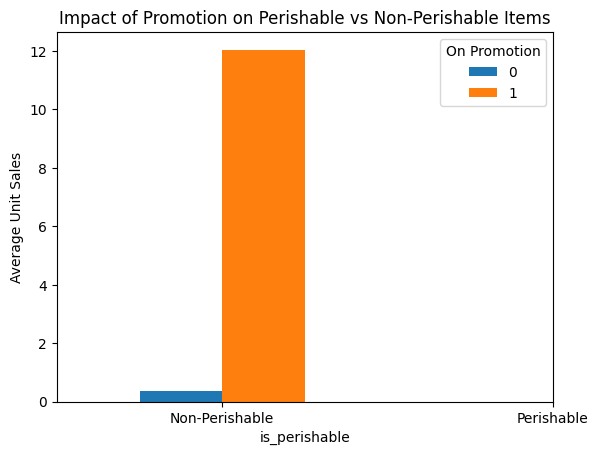

In [ ]:
# Group by perishable and promotion
promotion_effect = df_train.groupby(['is_perishable', 'onpromotion'])['unit_sales'].mean().unstack()

# Plotting
promotion_effect.plot(kind='bar')
plt.title('Impact of Promotion on Perishable vs Non-Perishable Items')
plt.ylabel('Average Unit Sales')
plt.xticks([0, 1], ['Non-Perishable', 'Perishable'], rotation=0)
plt.legend(title='On Promotion')
plt.show()